# Merge all datasets

## Load data

In [122]:
import pandas as pd

In [123]:
#load levels
df_level_2020 = pd.read_csv("level/2020.txt", sep=';', names=['DATE', 'A', 'LEVEL', 'DUMMY'])
df_level_2021 = pd.read_csv("level/2021.txt", sep=';', names=['DATE', 'A', 'LEVEL', 'DUMMY'])
df_level_2022 = pd.read_csv("level/2022.txt", sep=';', names=['DATE', 'A', 'LEVEL', 'DUMMY'])
df_level = pd.concat([df_level_2020, df_level_2021, df_level_2022])
df_level = df_level.drop(columns=['A','DUMMY'])
df_level["DATE"] = pd.to_datetime(df_level["DATE"])

df_level.head()


,DATE,LEVEL
0,2020-01-01 00:00:00,28
1,2020-01-01 00:05:00,29
2,2020-01-01 00:10:00,30
3,2020-01-01 00:15:00,30
4,2020-01-01 00:20:00,30


In [124]:
#load wind_speed
df_windsp_2020 = pd.read_csv("wind_speed/2020.txt", sep=';', names=['DATE', 'V', 'WSPEED', 'DUMMY'])
df_windsp_2021 = pd.read_csv("wind_speed/2021.txt", sep=';', names=['DATE', 'V', 'WSPEED', 'DUMMY'])
df_windps_2022 = pd.read_csv("wind_speed/2022.txt", sep=';', names=['DATE', 'V', 'WSPEED', 'DUMMY'])
df_windsp = pd.concat([df_windsp_2020, df_windsp_2021, df_windps_2022])
df_windsp = df_windsp.drop(columns=['V','DUMMY'])
df_windsp["DATE"] = pd.to_datetime(df_windsp["DATE"])

df_windsp.head()

,DATE,WSPEED
0,2020-01-01 00:00:00,3.2
1,2020-01-01 00:05:00,3.4
2,2020-01-01 00:10:00,3.3
3,2020-01-01 00:15:00,3.5
4,2020-01-01 00:20:00,3.4


In [125]:
#load wind_dir
df_winddir_2020 = pd.read_csv("wind_dir/2020.txt", sep=';', names=['DATE', 'D', 'WDIR', 'DUMMY'])
df_winddir_2021 = pd.read_csv("wind_dir/2021.txt", sep=';', names=['DATE', 'D', 'WDIR', 'DUMMY'])
df_winddir_2022 = pd.read_csv("wind_dir/2022.txt", sep=';', names=['DATE', 'D', 'WDIR', 'DUMMY'])
df_winddir = pd.concat([df_winddir_2020, df_winddir_2021, df_winddir_2022])
df_winddir = df_winddir.drop(columns=['D','DUMMY'])
df_winddir["DATE"] = pd.to_datetime(df_winddir["DATE"])

df_winddir.head()

,DATE,WDIR
0,2020-01-01 00:00:00,308
1,2020-01-01 00:05:00,315
2,2020-01-01 00:10:00,322
3,2020-01-01 00:15:00,324
4,2020-01-01 00:20:00,319


In [126]:
#load pressure
df_press_2020 = pd.read_csv("pressure/2020.txt", sep=';', names=['DATE','P', 'PRESS', 'DUMMY'])
df_press_2021 = pd.read_csv("pressure/2021.txt", sep=';', names=['DATE','P', 'PRESS', 'DUMMY'])
df_press_2022 = pd.read_csv("pressure/2022.txt", sep=';', names=['DATE','P', 'PRESS', 'DUMMY'])
#df_press_2023 = pd.read_csv("pressure/2023.txt", sep=';', names=['DATE','P', 'PRESS', 'DUMMY'])
df_press = pd.concat([df_press_2020, df_press_2021, df_press_2022])
df_press = df_press.drop(columns=['P','DUMMY'])
df_press["DATE"] = pd.to_datetime(df_press["DATE"])

df_press.head()

,DATE,PRESS
0,2020-01-01 00:00:00,1030.8
1,2020-01-01 00:05:00,1030.8
2,2020-01-01 00:10:00,1030.9
3,2020-01-01 00:15:00,1030.9
4,2020-01-01 00:20:00,1030.9


In [127]:
#load temperature
df_temp_2020 = pd.read_csv("temperature/2020.txt", sep=';', names=['DATE','T', 'TEMP', 'DUMMY'])
df_temp_2021 = pd.read_csv("temperature/2021.txt", sep=';', names=['DATE','T', 'TEMP', 'DUMMY'])
df_temp_2022 = pd.read_csv("temperature/2022.txt", sep=';', names=['DATE','T', 'TEMP', 'DUMMY'])
#df_temp_2023 = pd.read_csv("temperature/2023.txt", sep=';', names=['DATE','T', 'TEMP', 'DUMMY'])
df_temp = pd.concat([df_temp_2020, df_temp_2021, df_temp_2022])
df_temp = df_temp.drop(columns=['T','DUMMY'])
df_temp["DATE"] = pd.to_datetime(df_temp["DATE"])

df_temp.head()

,DATE,TEMP
0,2020-01-01 00:00:00,6.6
1,2020-01-01 00:05:00,6.7
2,2020-01-01 00:10:00,6.7
3,2020-01-01 00:15:00,6.7
4,2020-01-01 00:20:00,6.5


In [128]:
#TODO Handle rain

#load rain
df_rain_2020 = pd.read_csv("rain/2020.txt", sep=';', names=['DATE','R', 'RAIN', 'DUMMY'])
df_rain_2021 = pd.read_csv("rain/2021.txt", sep=';', names=['DATE','R', 'RAIN', 'DUMMY'])
df_rain_2022 = pd.read_csv("rain/2022.txt", sep=';', names=['DATE','R', 'RAIN', 'DUMMY'])
#df_rain_2023 = pd.read_csv("rain/2023.txt", sep=';', names=['DATE','R', 'RAIN', 'DUMMY'])
df_rain = pd.concat([df_rain_2020, df_rain_2021, df_rain_2022])
df_rain = df_rain.drop(columns=['R','DUMMY'])
df_rain["DATE"] = pd.to_datetime(df_rain["DATE"])

df_rain.head()

,DATE,RAIN
0,2020-01-01 00:00:00,0.0
1,2020-01-01 00:05:00,0.0
2,2020-01-01 00:10:00,0.0
3,2020-01-01 00:15:00,0.0
4,2020-01-01 00:20:00,0.0


## Run Join

In [129]:
# Create a DatetimeIndex with timestamps at 5-minute intervals
date_range = pd.date_range(start='2020-01-01 00:00:00', end='2022-12-31 23:55:00', freq='5T')

# Create a DataFrame with a single column containing the timestamps
df_venice = pd.DataFrame(date_range, columns=['DATE'])

desidered = df_venice.shape[0]

df_venice = pd.merge(df_venice, df_level, how="inner", on=["DATE"])
df_venice = pd.merge(df_venice, df_press, how="outer", on=["DATE"])
df_venice = pd.merge(df_venice, df_winddir, how="outer",on=["DATE"])
df_venice = pd.merge(df_venice, df_windsp, how="outer",on=["DATE"])
df_venice = pd.merge(df_venice, df_temp, how="outer",on=["DATE"])
df_venice = pd.merge(df_venice, df_rain, how="outer", on=["DATE"])

#df_venice["DATE"] = pd.to_datetime(df_venice["DATE"])

df_venice_small = df_venice[(df_venice["DATE"].dt.minute == 0) | (df_venice["DATE"].dt.minute == 30)]
df_venice_small.reset_index(drop=True, inplace=True)

df_venice.to_csv('venice.csv')
df_venice_small.to_csv('venice_small.csv')
df_venice.head()
got = df_venice.shape[0]
print(desidered, got)

315648 315646


## Plot Data

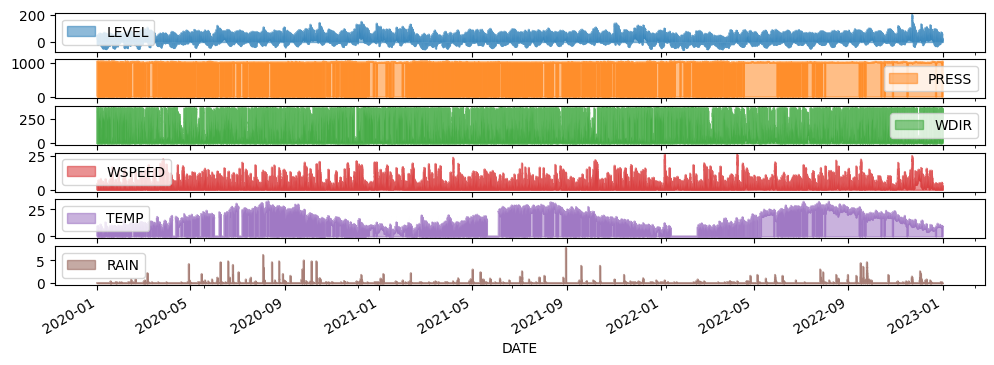

In [130]:


veniceplot = df_venice.plot.area(x="DATE", figsize=(12,4),stacked=False,subplots=True)